In [2]:
# import libraries
import pandas as pd
from PIL import Image
import matplotlib.pyplot as mat
import seaborn as sns
import os
import cv2 
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score , classification_report
import pickle
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
import gc
from skimage.color import rgb2gray

Ans-1 (a)

In [10]:
data1Label = pd.read_csv(r'data/label.csv') #reading the label file 
data1Classes = data1Label['label'].value_counts() #counting the number of classes in the dataset
print(data1Classes) #printing the number of classes in the dataset

label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64


In [11]:
imagesSizes = [] # to store the sizes of the images
for imageVal in os.listdir(r'data/data')[:500]: # to get the sizes of the first 500 images
    imageP = Image.open(os.path.join(r'data/data/' , imageVal)) # open the image
    imagesSizes.append(imageP.size) # get the size of the image
imagesDataFrame = pd.DataFrame(imagesSizes , columns=['width' , 'height']) # create a dataframe of the sizes
print(imagesDataFrame.describe())

            width      height
count  500.000000  500.000000
mean   263.990000  193.024000
std     37.363002   32.032665
min    136.000000   84.000000
25%    259.000000  178.000000
50%    275.000000  183.000000
75%    278.000000  194.000000
max    426.000000  286.000000


In [12]:
# no of mising values
print(data1Label.isnull().sum())# there are no missing values , as we can see
# there are no missing values , as we can see
typeFile = [x.split('.')[-1] for x in os.listdir(r'data/data/')]# getting the type of file
print(pd.Series(typeFile).value_counts())

filename    0
label       0
dtype: int64
jpg    12601
Name: count, dtype: int64


Ans 1 (b)

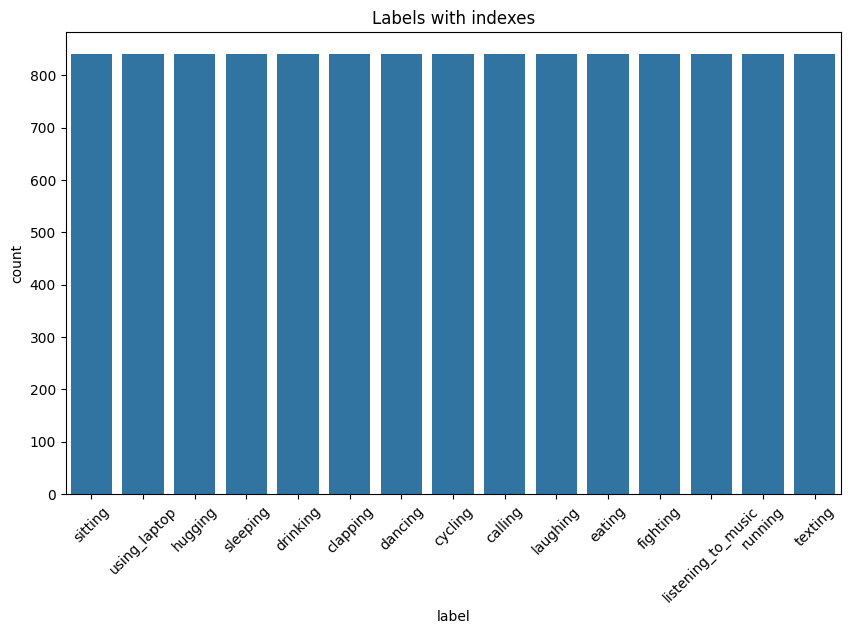

In [13]:
mat.figure(figsize=(10 , 6)) # setting the figure size
sns.countplot(x = 'label' , data = data1Label , order=data1Label['label'].value_counts().index) # plotting the countplot
mat.title('Labels with indexes')# setting the title
mat.xticks(rotation = 45)#  rotating the xticks
mat.show()# showing the plot

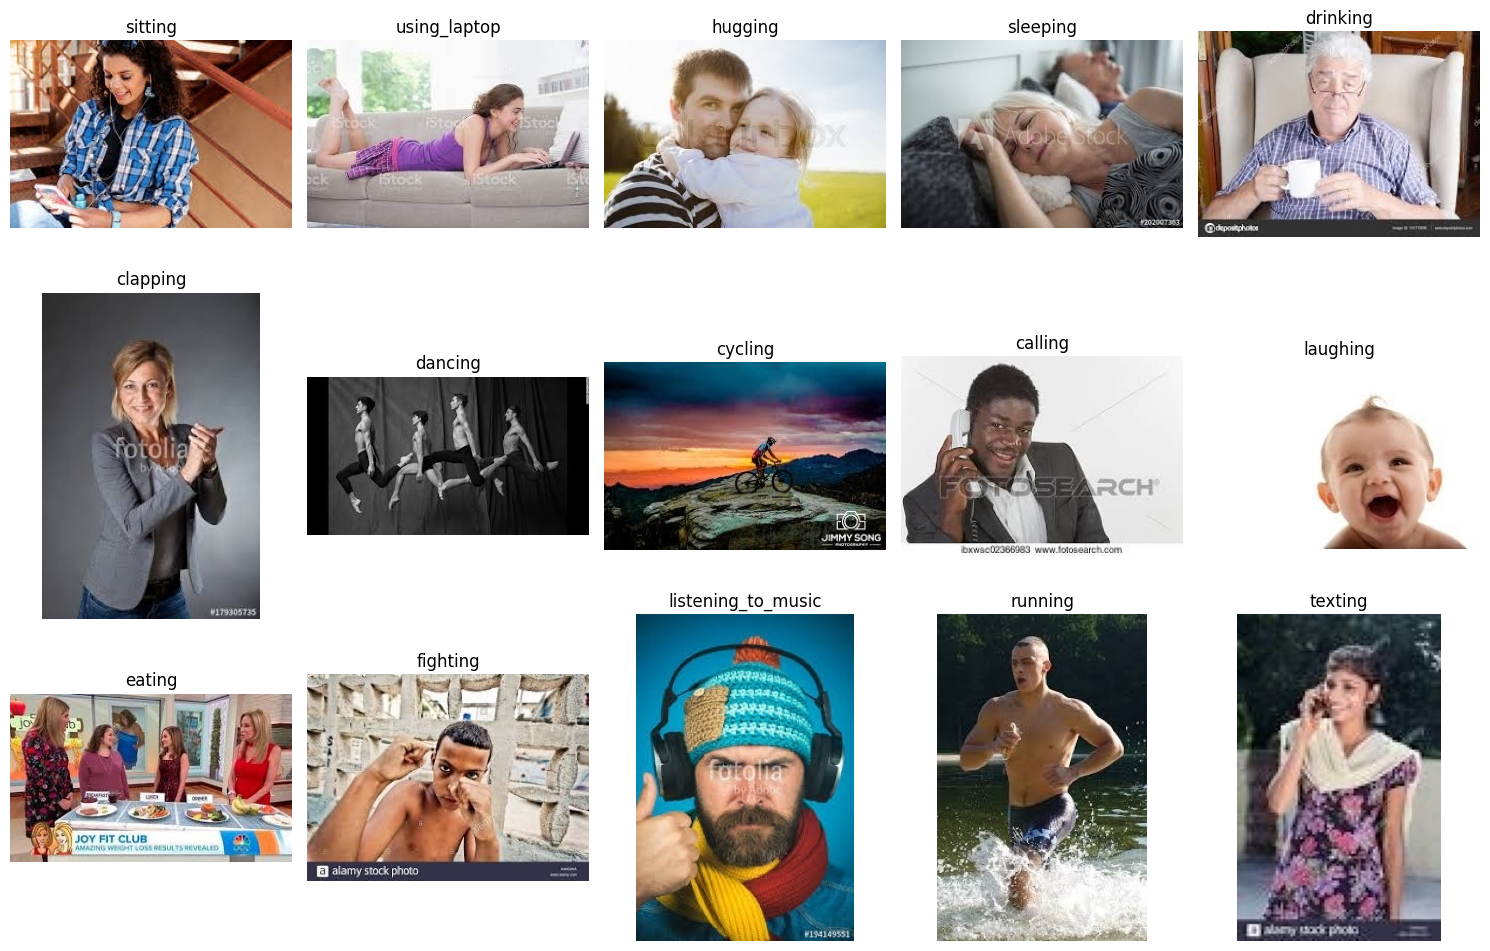

In [14]:
fig , axes = mat.subplots(3 , 5 , figsize = (15 , 10)) # 3 rows and 5 columns
cnt = 0#    0 1 2 3 4
for i in data1Label['label'].unique():
    imageN = data1Label[data1Label['label'] == i].iloc[0]['filename']
    imageVal = Image.open(os.path.join(r'data/data' , imageN)) # open image
    r = cnt//5 ; c = cnt%5
    ax =axes[r , c]# 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2
    ax.imshow(imageVal)
    ax.set_title(i)# set title
    ax.axis('off')
    cnt += 1
mat.tight_layout()
mat.show()

Ans 1(c) - There was no imbalance in the classes , every class had 840 samples.

Ans 2

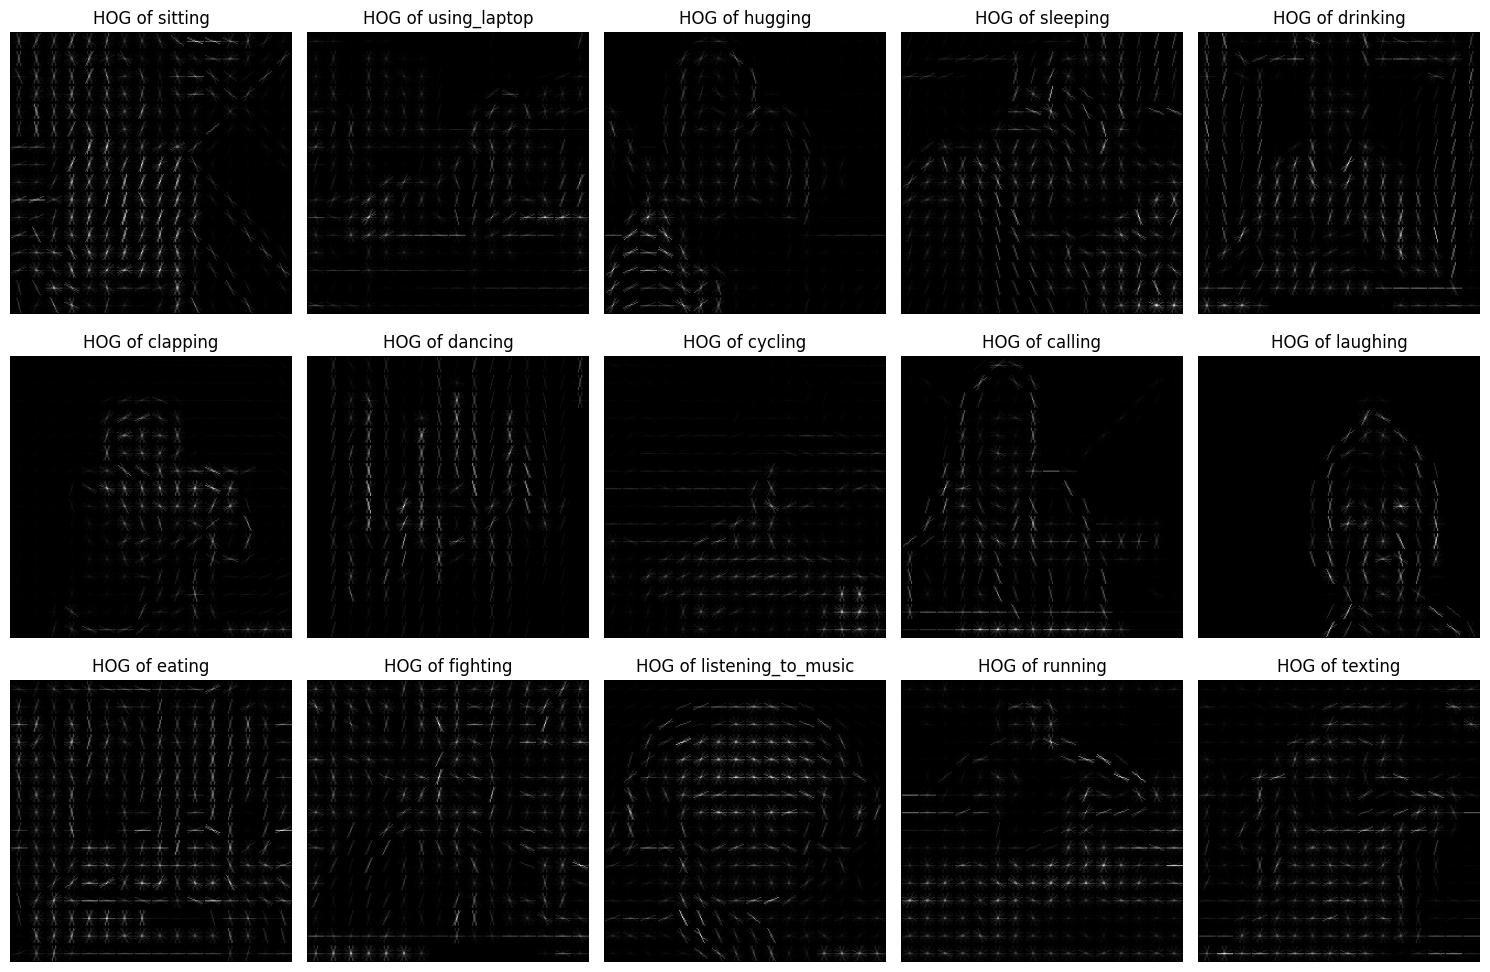

In [15]:
def hogFeatures(image): # hog features
    resizedImage = cv2.resize(image , (256 , 256))
    grayImage = cv2.cvtColor(resizedImage , cv2.COLOR_BGR2GRAY)
    hogFeaturesVal  , hogImage = hog(grayImage , orientations=9  ,pixels_per_cell=(16,16) , cells_per_block=(4 , 4) , visualize=True)
    return hogFeaturesVal , hogImage
def hogFeaturesfn(image): # hog features
    imageResized = cv2.resize(image , (256 , 256))
    resizedImage = cv2.resize(image , (256 , 256))
    grayImage = cv2.cvtColor(resizedImage , cv2.COLOR_BGR2GRAY)
    hogFeaturesVal  , hogImage = hog(grayImage , orientations=9  ,pixels_per_cell=(16,16) , cells_per_block=(4 , 4) , visualize=True)
    return hogFeaturesVal
def histogram(image): # histogram features
    histR = cv2.calcHist([image] , [0] , None , [256] , [ 0 , 256])
    histG = cv2.calcHist([image] , [1] , None , [256] , [0 , 256])
    histB = cv2.calcHist([image] , [2] , None , [256] , [0 , 256])
    histFeatures =  np.concatenate([histR ,histG , histB]).flatten()
    return histR , histG , histB , histFeatures
def histogramfn(image):
    histR = cv2.calcHist([image] , [0] , None , [256] , [ 0 , 256])
    histG = cv2.calcHist([image] , [1] , None , [256] , [0 , 256])
    histB = cv2.calcHist([image] , [2] , None , [256] , [0 , 256])
    histFeatures =  np.concatenate([histR ,histG , histB]).flatten()
    return histFeatures
classes = [] ; vals = [] 
fig , axes = mat.subplots(3 , 5 , figsize = (15 , 10)) 
for i , val in data1Label.iterrows():  # 
    pathImage = os.path.join(r'data/data' , val['filename']) # path of image
    image = cv2.imread(pathImage) # read image
    featuresGot = hogFeaturesfn(image) ; colors = histogramfn(image) # get features
    combinedFeatures = np.concatenate((featuresGot , colors))# combine features
    classes.append(combinedFeatures) ; vals.append(val['label']) # append to list
classes = np.array(classes) ; vals = np.array(vals)    
cnt = 0 
for i in data1Label['label'].unique(): # plot images
    imageN = data1Label[data1Label['label'] == i].iloc[0]['filename']# get image name
    imageVal = cv2.imread(os.path.join(r'data/data' , imageN))# read image
    hogFeature   , hogImage = hogFeatures(imageVal)# get hog features
    r=cnt//5 ; c = cnt%5 ; ax = axes[r , c] ;# plot image
    ax.imshow(hogImage , cmap='gray') ; ax.set_title(f'HOG of {i}') ; ax.axis('off')# plot image
    cnt += 1# increment count
cnt = 0
# for i in data1Label['label'].unique():
#     imageN = data1Label[data1Label['label'] == i].iloc[0]['filename']  # Get image name
#     imageVal = cv2.imread(os.path.join(r'data/data', imageN))  # Read image
    
#     # Get HOG and histogram visualizations
#     hogFeature, hogImage = hogFeatures(imageVal)
#     histR, histG, histB, _ = histogram(imageVal)
    
#     r = cnt // 5
#     c = cnt % 5
    
#     # Plot HOG feature
#     # ax = axes[r, c]
#     # ax.imshow(hogImage, cmap='gray')
#     # ax.set_title(f'HOG of {i}')
#     # ax.axis('off')
    
#     # Plot color histograms (RGB)
#     fig_hist, ax_hist = mat.subplots(1, 1, figsize=(5, 3))
#     ax_hist.plot(histR, color='r', label='Red Channel')
#     ax_hist.plot(histG, color='g', label='Green Channel')
#     ax_hist.plot(histB, color='b', label='Blue Channel')
#     ax_hist.set_title(f'Color Histogram of {i}')
#     ax_hist.set_xlabel('Pixel Intensity')
#     ax_hist.set_ylabel('Frequency')
#     ax_hist.legend()
#     mat.show()
    
#     cnt += 1

mat.tight_layout() ; mat.show()

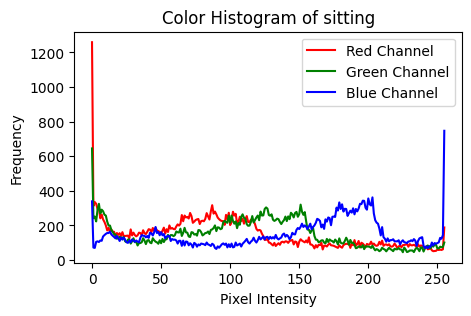

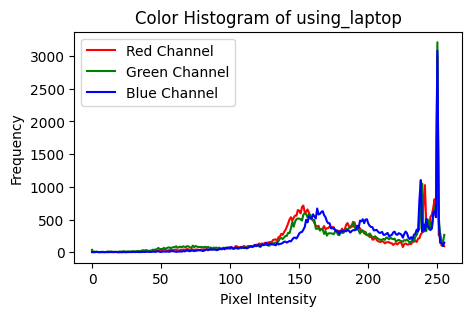

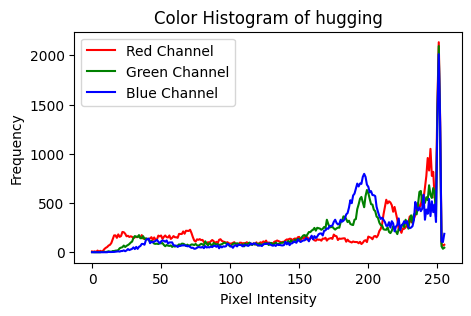

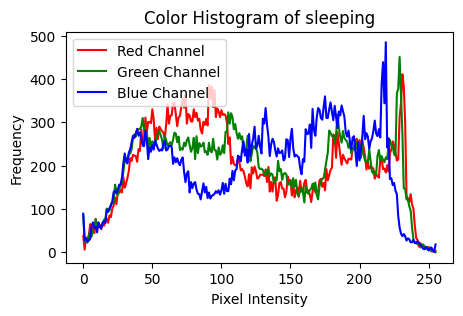

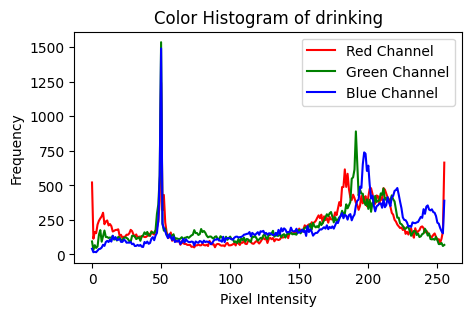

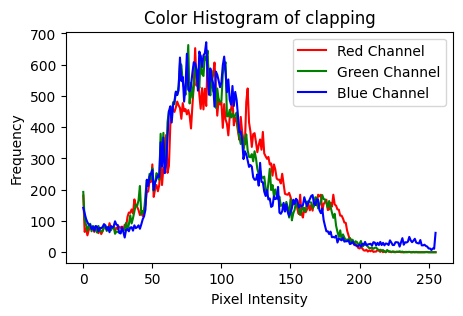

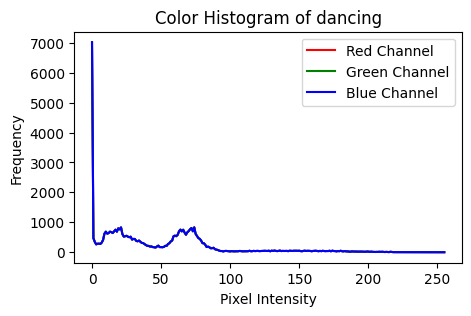

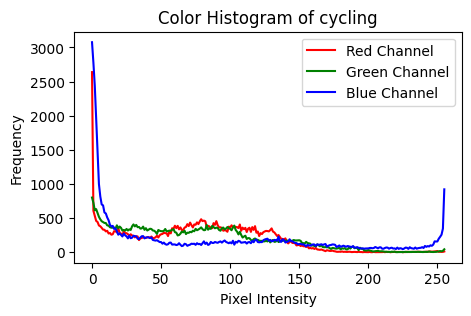

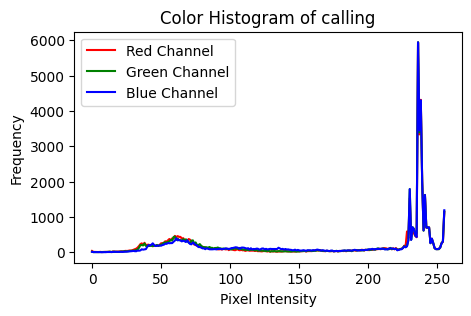

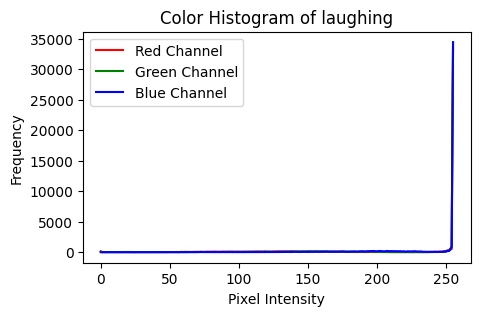

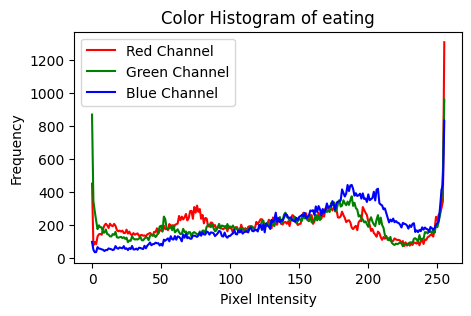

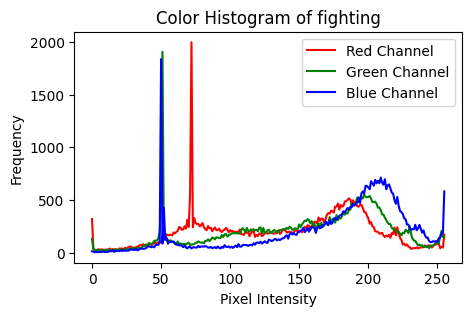

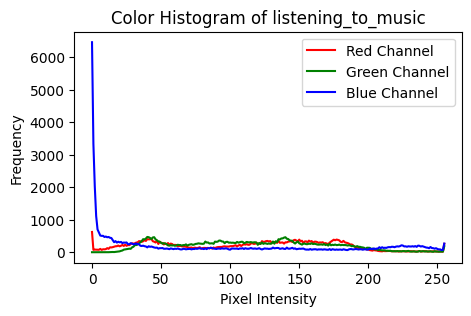

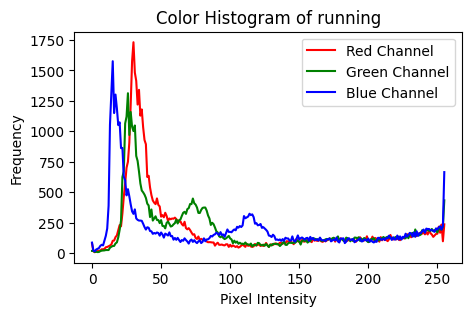

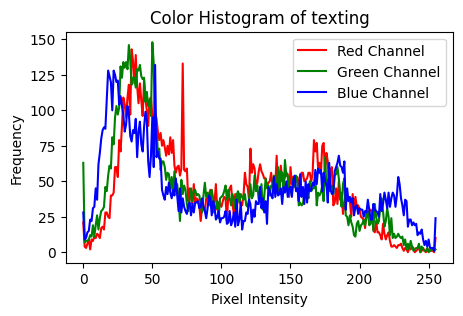

<Figure size 640x480 with 0 Axes>

In [16]:
# cnt = 0 
# for i in data1Label['label'].unique(): # plot images
#     imageN = data1Label[data1Label['label'] == i].iloc[0]['filename']# get image name
#     imageVal = cv2.imread(os.path.join(r'data/data' , imageN))# read image
#     hogFeature   , hogImage = hogFeatures(imageVal)# get hog features
#     r=cnt//5 ; c = cnt%5 ; ax = axes[r , c] ;# plot image
#     ax.imshow(hogImage , cmap='gray') ; ax.set_title(f'HOG of {i}') ; ax.axis('off')# plot image
#     cnt += 1# increment count
cnt = 0
for i in data1Label['label'].unique():
    imageN = data1Label[data1Label['label'] == i].iloc[0]['filename']  # Get image name
    imageVal = cv2.imread(os.path.join(r'data/data', imageN))  # Read image
    
    # Get HOG and histogram visualizations
    hogFeature, hogImage = hogFeatures(imageVal)
    histR, histG, histB, _ = histogram(imageVal)
    
    r = cnt // 5
    c = cnt % 5
    
    # Plot HOG feature
    # ax = axes[r, c]
    # ax.imshow(hogImage, cmap='gray')
    # ax.set_title(f'HOG of {i}')
    # ax.axis('off')
    
    # Plot color histograms (RGB)
    fig_hist, ax_hist = mat.subplots(1, 1, figsize=(5, 3))
    ax_hist.plot(histR, color='r', label='Red Channel')
    ax_hist.plot(histG, color='g', label='Green Channel')
    ax_hist.plot(histB, color='b', label='Blue Channel')
    ax_hist.set_title(f'Color Histogram of {i}')
    ax_hist.set_xlabel('Pixel Intensity')
    ax_hist.set_ylabel('Frequency')
    ax_hist.legend()
    mat.show()
    
    cnt += 1

mat.tight_layout() ; mat.show()

In [19]:
def extract_features(X):
    features = []
    for img in X:
        # Convert image to grayscale
        img_gray = rgb2gray(img)

        # Extract HOG features
        hog_features = hog(img_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

        # Color histograms for R, G, B channels
        hist_r = np.histogram(img[:, :, 0], bins=32, range=(0, 256))[0]
        hist_g = np.histogram(img[:, :, 1], bins=32, range=(0, 256))[0]
        hist_b = np.histogram(img[:, :, 2], bins=32, range=(0, 256))[0]
        color_hist = np.concatenate([hist_r, hist_g, hist_b])

        # Basic statistical features
        feature_stats = [
            np.mean(img),
            np.std(img),
            np.min(img),
            np.max(img),
            np.median(img),
            img.size  # Size of the image (number of pixels)
        ]

        # Combine all features
        combined_features = np.concatenate([hog_features, color_hist, feature_stats])
        features.append(combined_features)
    
    return np.array(features)

Ans 3

In [17]:
xTrain , xTest , yTrain , yTest =  train_test_split(classes , vals ,test_size  = 0.2 , random_state = 42) # 80% training and 20% testing

naiveModel = GaussianNB() # Naive Bayes
naiveModel.fit(xTrain , yTrain)
naivePredict = naiveModel.predict(xTest)
naiveAccuracy = accuracy_score(yTest , naivePredict)

decisionModel = DecisionTreeClassifier() # Decision Tree
decisionModel.fit(xTrain , yTrain)
decisionPrediction = decisionModel.predict(xTest)
decisionAccuracy = accuracy_score(yTest , decisionPrediction)

RandomForestModel = RandomForestClassifier() # Random Forest
RandomForestModel.fit(xTrain , yTrain)
RandomFOresprediction = RandomForestModel.predict(xTest)
RandomFOrestAcc = accuracy_score(yTest , RandomFOresprediction)

PerceptronModel = Perceptron() # Perceptron
PerceptronModel.fit(xTrain , yTrain)
PerceptronModelPredict = PerceptronModel.predict(xTest)
PerceptronAccuracy = accuracy_score(yTest , PerceptronModelPredict)
print(f'The accuracies are : \n Naive Bayes : {naiveAccuracy} \n Decision Tree : {decisionAccuracy} \n Random Forest : {RandomFOrestAcc} \n Perceptron : {PerceptronAccuracy}')




The accuracies are : 
 Naive Bayes : 0.16507936507936508 
 Decision Tree : 0.1392857142857143 
 Random Forest : 0.2611111111111111 
 Perceptron : 0.0988095238095238


In [20]:
fixed_size = (64, 64)
images_DIR = 'data/data/'

dataset_csv = pd.read_csv('data/label.csv')  # Update with correct CSV file if needed
y = dataset_csv['label'].values  # Assuming 'label' is the target column
X_new = []
for index, row in dataset_csv.iterrows():
    image_path = os.path.join(images_DIR, row['filename'])
    with Image.open(image_path) as img:
        img_resized = img.resize(fixed_size)
        img_array = np.array(img_resized)
        X_new.append(img_array)

# Function to extract features (HOG + Color Histogram + Basic Stats)
X_features = extract_features(X_new)
# Split the data into training and test sets (80:20 split)
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42, stratify=y)
# Scale the feature data using Min-Max scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train LightGBM Classifier
lgb_classifier = lgb.LGBMClassifier(n_estimators=500, max_depth=15, random_state=42)
lgb_classifier.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_lgb = lgb_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print(f'LightGBM Accuracy: {accuracy_lgb * 100:.2f}%')
print("\nLightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))

# Clean up memory
gc.collect()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 475156
[LightGBM] [Info] Number of data points in the train set: 10080, number of used features: 1865
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[Ligh

44

In [3]:
with open('lightbgm_model.pkl', 'wb') as model_file:
    pickle.dump(lgb_classifier, model_file)
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)
with open('test_data.pkl', 'wb') as test_data_file:
    pickle.dump({'X_test': X_test_scaled, 'y_test': y_test}, test_data_file)
yPredict = lgb_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test , yPredict)
print(f'LightGBM Accuracy: {accuracy * 100:.2f}% \n LightGBM Classification Report: \n {classification_report(y_test, yPredict)}')

NameError: name 'lgb_classifier' is not defined

In [5]:
with open('lightbgm_model.pkl', 'rb') as model_file:
    lgb_model = pickle.load(model_file)
with open('scaler.pkl', 'rb') as scaler_file:
    loaded_scaler = pickle.load(scaler_file)
with open('test_data.pkl', 'rb') as test_data_file:
    test_data = pickle.load(test_data_file)
    XtestScaled = test_data['X_test']
    Ytest = test_data['y_test']
XtestScaled = loaded_scaler.transform(X_test)
yPredict = lgb_model.predict(XtestScaled)
accuracy = accuracy_score(y_test , yPredict)
print(f'LightGBM Accuracy: {accuracy * 100:.2f}% \n LightGBM Classification Report: \n {classification_report(y_test, yPredict)}')

EOFError: Ran out of input